<a href="https://colab.research.google.com/github/crissyro/Deep-learning-courses/blob/main/notebooks/nn_sap_auc_82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             RocCurveDisplay)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [183]:
np.random.seed(42)

In [184]:
df = pd.read_csv('/content/output.csv')
df

,Country,Year,House Price Index,Rent Index,Affordability Ratio,Mortgage Rate (%),Inflation Rate (%),GDP Growth (%),Population Growth (%),Urbanization Rate (%),Construction Index,label
0,USA,2015,117.454012,116.550001,9.587945,4.493292,1.514121,-0.752044,-0.796707,85.985284,118.089201,1
1,USA,2016,150.807258,51.440915,11.729189,5.662213,1.880204,-0.545400,-0.358084,69.127267,111.980515,1
2,USA,2017,123.194502,70.386040,8.506676,2.197469,2.398940,0.930895,0.596245,83.555279,85.973903,1
3,USA,2018,131.423444,91.469020,3.418054,4.537724,1.608407,-1.479587,2.321099,88.968961,134.671788,1
4,USA,2019,110.461377,56.837048,9.158097,3.700762,1.293249,1.961415,-0.879640,87.279612,90.702399,1
...,...,...,...,...,...,...,...,...,...,...,...,...
195,UAE,2020,160.153711,117.170365,7.390686,2.048681,4.061737,1.635019,1.955250,62.942477,109.059291,0
196,UAE,2021,95.004866,72.727315,9.636214,3.880091,2.943274,1.155810,0.608064,83.550496,141.366775,1
197,UAE,2022,175.533469,105.083237,5.838662,4.940674,3.344420,0.037365,1.943051,61.152790,142.140959,0
198,UAE,2023,126.147746,94.604103,8.934185,5.975589,4.638353,2.911469,-0.766718,75.552241,82.013520,1


In [185]:
X = df.drop(['label'], axis=1)
y = df['label']

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

In [186]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

X = preprocessor.fit_transform(X)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [188]:
X_train_tensor = torch.tensor(X_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.tolist(), dtype=torch.float32)

In [189]:
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32).view(-1, 1)

In [190]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)


In [236]:
class FC_NN(nn.Module):
  def __init__(self, input_size, dropout_p=0.3):
    super().__init__()
    self.fc1 = nn.Linear(input_size, 8)
    self.fc2 = nn.Linear(8, 1)
    self.relu = nn.ReLU()
    self.dr = nn.Dropout(dropout_p)

  def forward(self, X):
    res = self.fc1(X)
    res = self.relu(res)
    res = self.dr(res)
    res = self.fc2(res)
    return torch.sigmoid(res)

In [237]:
input_size = X_train.shape[1]
model = FC_NN(input_size)

In [238]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [239]:
def train(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    num_epochs: int = 200,
    batch_size: int = 32,
    learning_rate: float = 0.001,
    model: nn.Module = None,
    optimizer: torch.optim.Optimizer = None,
    criterion: nn.Module = None
) -> nn.Module:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train, y_train = X_train.float().to(device), y_train.float().to(device)
    X_test, y_test = X_test.float().to(device), y_test.float().to(device)

    model = model.to(device)

    if criterion is None:
        criterion = nn.BCELoss()

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()

        with torch.no_grad():
            train_loss = epoch_loss / len(train_loader)
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test.view(-1, 1)).item()

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    model.eval()

    with torch.no_grad():
        y_proba = model(X_test).detach().cpu().numpy().flatten()
        y_pred = (y_proba > 0.5).astype(int)
        y_true = y_test.detach().cpu().numpy().flatten()

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

    plt.figure(figsize=(18, 12))

    plt.subplot(2, 3, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')

    plt.subplot(2, 3, 3)
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title('ROC Curve')

    plt.subplot(2, 3, (5, 6))
    metric_items = list(metrics.items())

    plt.table(
        cellText=[[f"{v:.4f}"] for _, v in metric_items],
        rowLabels=[k for k, _ in metric_items],
        colLabels=['Value'],
        loc='center',
        cellLoc='center',
        colWidths=[0.3]
    )

    plt.axis('off')
    plt.title('Classification Metrics', fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

    return model


Epoch 5/80 | Train Loss: 0.6983 | Test Loss: 0.6949
Epoch 10/80 | Train Loss: 0.6828 | Test Loss: 0.6872
Epoch 15/80 | Train Loss: 0.6759 | Test Loss: 0.6793
Epoch 20/80 | Train Loss: 0.6569 | Test Loss: 0.6699
Epoch 25/80 | Train Loss: 0.6518 | Test Loss: 0.6589
Epoch 30/80 | Train Loss: 0.6264 | Test Loss: 0.6466
Epoch 35/80 | Train Loss: 0.6167 | Test Loss: 0.6335
Epoch 40/80 | Train Loss: 0.5787 | Test Loss: 0.6213
Epoch 45/80 | Train Loss: 0.5622 | Test Loss: 0.6100
Epoch 50/80 | Train Loss: 0.5430 | Test Loss: 0.5979
Epoch 55/80 | Train Loss: 0.5193 | Test Loss: 0.5862
Epoch 60/80 | Train Loss: 0.5067 | Test Loss: 0.5762
Epoch 65/80 | Train Loss: 0.4930 | Test Loss: 0.5684
Epoch 70/80 | Train Loss: 0.4726 | Test Loss: 0.5625
Epoch 75/80 | Train Loss: 0.4471 | Test Loss: 0.5571
Epoch 80/80 | Train Loss: 0.4455 | Test Loss: 0.5533


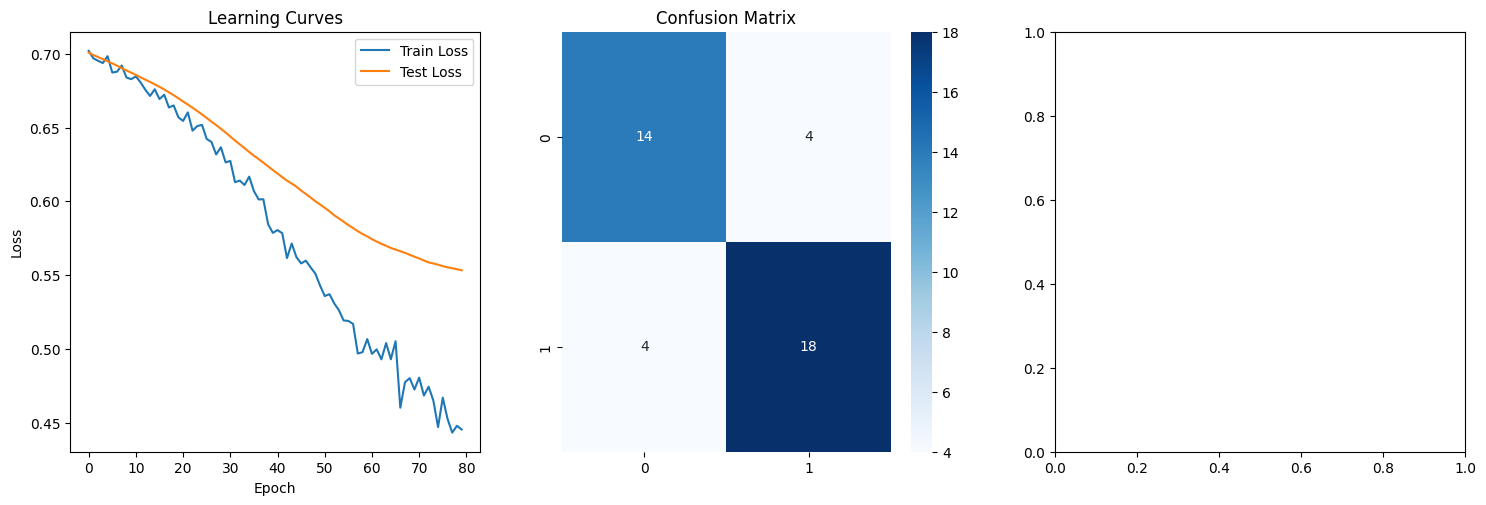

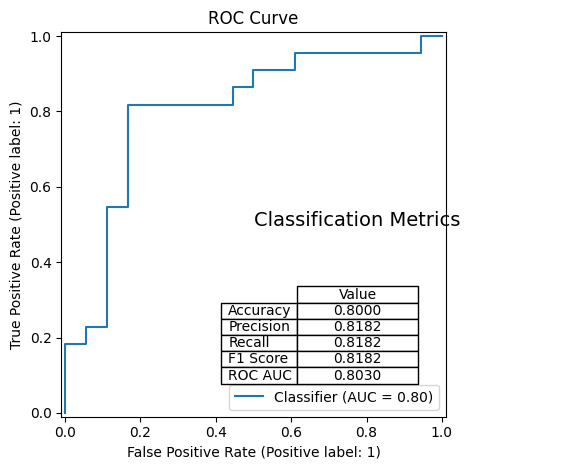

FC_NN(
  (fc1): Linear(in_features=30, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dr): Dropout(p=0.3, inplace=False)
)

In [240]:
train(
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    80,
    32,
    0.0001,
    model,
    optimizer=optimizer,
)